In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from dcgan.nn import Generator, Discriminator
from dcgan.utils import init_weights, show_batch, save_batch
from dcgan.dataset import FacesDataset

from tqdm.notebook import tqdm

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
batch_size = 128
image_size = 128
n_channels = 3
z_size = 100
n_features_g = 128
n_features_d = 128
n_layers_g = 5
n_layers_d = 5
n_epochs = 100
lr = 2e-4
betas = (0.5, 0.999)

real_label = 1
fake_label = 0

folder = '/Users/cheremushkin/Documents/datasets/simpsons/'

In [15]:
g = Generator(z_size=z_size,
              n_features=n_features_g,
              n_layers=n_layers_g,
              n_channels=n_channels)
g.apply(init_weights).to(device)

Generator(
  (blocks): ModuleList(
    (0): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(100, 3200, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (1): BatchNorm2d(3200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(3200, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvTransposeBlock(
      (block): Sequential(
        (0): ConvTranspos

In [6]:
d = Discriminator(n_channels=n_channels,
                  n_features=n_features_d,
                  n_layers=n_layers_d)
d.apply(init_weights).to(device)

Discriminator(
  (blocks): ModuleList(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (3): ConvBlock(
      (block): Sequential(
 

In [7]:
transforms = A.Compose([
    A.Resize(image_size, image_size),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(p=1)
])

ds = FacesDataset(folder=folder, transforms=transforms)
dl = DataLoader(dataset=ds, batch_size=batch_size, shuffle=True, num_workers=2)

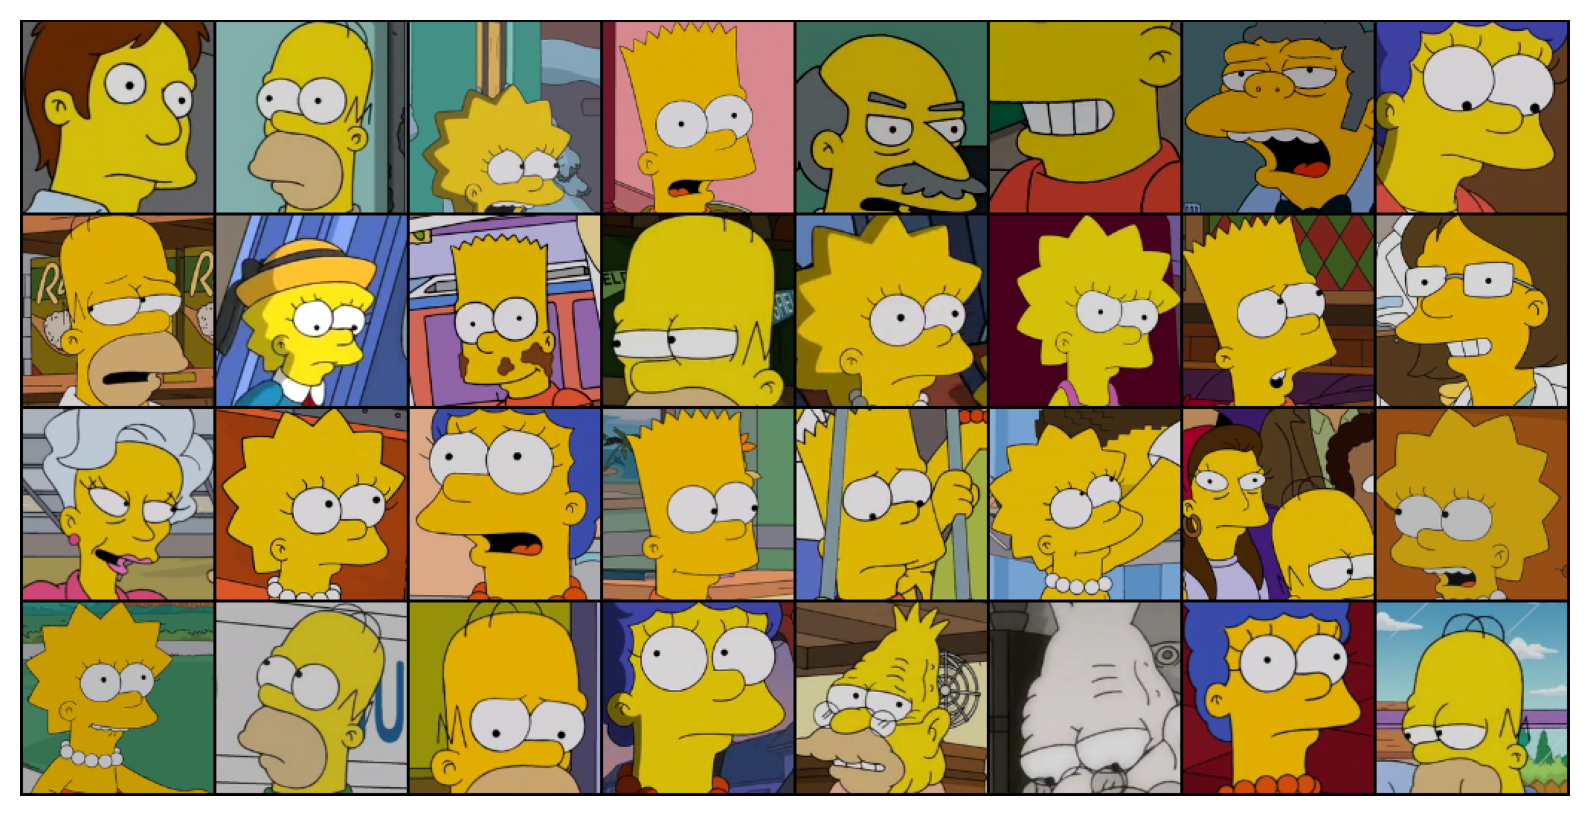

In [8]:
show_batch(next(iter(dl)))

In [9]:
criterion = nn.BCELoss()

opt_d = optim.Adam(d.parameters(), lr=lr, betas=betas)
opt_g = optim.Adam(g.parameters(), lr=lr, betas=betas)

In [11]:
fixed_noise = torch.randn(batch_size, z_size, 1, 1, device=device)

g_losses = []
d_losses = []

In [18]:
n_iter = 0
for epoch in tqdm(range(n_epochs)):
    for i, xb in tqdm(enumerate(dl, 0), leave=False, total=len(dl)):
        # Discriminator
        d.zero_grad()
        real = xb.to(device)
        label = torch.full((xb.size(0),), real_label, dtype=torch.float, device=device)
        real_output = d(real).view(-1)
        loss_real_d = criterion(real_output, label)
        loss_real_d.backward()

        noise = torch.randn(xb.size(0), z_size, 1, 1, device=device)
        fake = g(noise)
        label = torch.full((xb.size(0),), fake_label, dtype=torch.float, device=device)
        fake_output = d(fake.detach()).view(-1)
        loss_fake_d = criterion(fake_output, label)
        loss_fake_d.backward()
        
        loss_d = loss_real_d + loss_fake_d
        opt_d.step()
        
        # Generator
        g.zero_grad()
        label = torch.full((xb.size(0),), real_label, dtype=torch.float, device=device)
        fake_output = d(fake).view(-1)
        loss_g = criterion(fake_output, label)
        loss_g.backward()
        opt_d.step()
        
        d_losses.append(loss_d.item())
        g_losses.append(loss_g.item())
        
        if i % 10 == 0:
            print(f'[{epoch}/{n_epochs}][{i}/{len(dataloader)}]\t \
                  Loss_D: {loss_d.item():.4f}\tLoss_G: {loss_g.item():.4f}')

        if (n_iter % 10 == 0) or ((epoch == n_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = g(fixed_noise).detach().cpu()
            save_batch(fake)

        iters += 1

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

NameError: name 'optimizerG' is not defined